# ``eBOSS`` Quasar Luminosity Function

Initiate notebook.

In [1]:
from pprint import pprint

import corner
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.cosmology import Planck15
from matplotlib import rcParams
from mpl_toolkits import mplot3d

rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'

from conf import PATH
from horizonground.lumfunc_likelihood import LumFuncMeasurements
from horizonground.lumfunc_modeller import (
    LumFuncModeller,
    quasar_PLE_model,
    quasar_hybrid_model,
)
from horizonground.utils import process_header

Define parameter ranges.

In [2]:
REDSHIFT_RANGE = 0., 3.
MAGNITUDE_RANGE = -29.0, -20.6
DENSITY_RANGE = pow(10, -9.225), pow(10, -4.775)

## ``eBOSS`` Luminosity function data

Load luminosity function data in redshift bins.

In [3]:
MEASUREMENTS_FILE = PATH/"external"/"eBOSS_QSO_LF_measurements.txt"
UNCERTAINTIES_FILE = PATH/"external"/"eBOSS_QSO_LF_uncertainties.txt"

luminosity_function_data = LumFuncMeasurements(
    MEASUREMENTS_FILE, UNCERTAINTIES_FILE, base10_log=False
)

## Luminosity function model

Specify luminosity function model.

In [4]:
modeller = LumFuncModeller.from_parameters_file(
    parameter_file="../data/external/eBOSS_QSO_LF_PLE_model_fits.txt",
    lumfunc_model=quasar_PLE_model,
    brightness_variable='magnitude',
    threshold_value=-21.80,
    threshold_variable='magnitude',
    cosmology=Planck15,
    base10_log=False,
)

luminosity_function_model = modeller.luminosity_function

Visualise luminosity function surface.

Text(0.5, 0, '$\\Phi(m,z)$ [$\\textrm{Mpc}^{-3} \\textrm{mag}^{-1}$]')

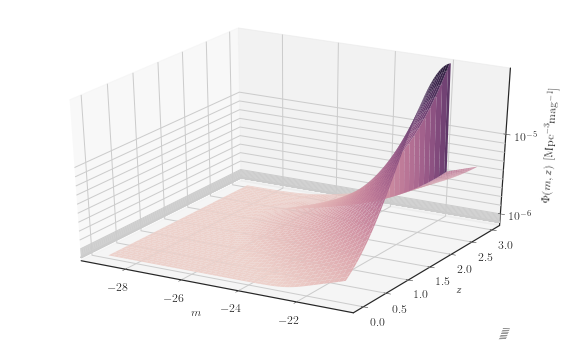

In [5]:
NUM_MESH = 100

magnitudes = np.linspace(*MAGNITUDE_RANGE, num=NUM_MESH, endpoint=False)
redshifts = np.linspace(*REDSHIFT_RANGE, num=NUM_MESH, endpoint=False)
m, z = np.meshgrid(magnitudes, redshifts)
Phi = luminosity_function_model(m, z)

fig = plt.figure("Luminosity function surface", figsize=(10, 6))
ax = plt.axes(projection='3d')

ax.plot_surface(
    m, z, Phi,
    cmap=sns.cubehelix_palette(as_cmap=True),
    edgecolor='none'
)

ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$z$")

ax.set_zlim(*DENSITY_RANGE)
ax.set_zscale('log')
ax.set_zticks([pow(10, -5), pow(10, -6)])
ax.set_zlabel(r"$\Phi(m,z)$ [$\textrm{Mpc}^{-3} \textrm{mag}^{-1}$]")

## ``eBoss`` quasar luminosity function results

Load sample MCMC chains and construct models from each sample model point.

In [6]:
model_param_chain_file0 = (
    "../data/output/cabinet/eBOSS_QSO_LF_PLE_zeus_1512631_32_5E5_by1.h5"
)

model_param_chain_file1 = (
    "../data/output/eBOSS_QSO_LF_PLE_zeus_1544064_20_5E4_by1.h5"
)

burnin, reduce = 10000, 30
with h5py.File(model_param_chain_file0, 'r') as chain_data:
    chain0 = chain_data['mcmc']['chain'][()]
    nparam = chain0.shape[-1]
    chain_flat0 = chain0[:, burnin::reduce, :].reshape((-1, nparam))

burnin, reduce = 500, 1
with h5py.File(model_param_chain_file1, 'r') as chain_data:
    chain1 = chain_data['mcmc']['chain'][()]
    nparam = chain1.shape[-1]
    chain_flat1 = chain1[burnin::reduce, :, :].reshape((-1, nparam))

In [7]:
with open("../data/input/cabinet/QSO_LF_PLE_model_fixed.txt") as f:
    param_names = process_header(f.readline())

one_sigma_quantiles0 = np.asarray([
    corner.quantile(chain_flat0[:, i], q=[0.1587, 0.8413])
    for i in range(nparam)
])

one_sigma_quantiles1 = np.asarray([
    corner.quantile(chain_flat0[:, i], q=[0.1587, 0.8413])
    for i in range(nparam)
])

reference_quantiles = np.asarray([
    [-26.86, -26.56], [-6.08, -5.94],
    [-4.57, -4.05], [-3.16, -2.92],
    [-1.58, -1.50], [-1.45, -1.31],
    [-0.16, 0.00], [-0.34, -0.16],
    [-0.45, -0.35], [-0.11, 0.01]
    
])

within_one_sigma_model0 = [
    model_point for model_point in chain_flat0
    if np.all(model_point > one_sigma_quantiles0[:, 0])
    and np.all(model_point < one_sigma_quantiles0[:, 1])
]

within_one_sigma_model1 = [
    model_point for model_point in chain_flat1
    if np.all(model_point > one_sigma_quantiles1[:, 0])
    and np.all(model_point < one_sigma_quantiles1[:, 1])
]

reference_models0 = [
    model_point for model_point in chain_flat0
    if np.all(model_point > reference_quantiles[:, 0])
    and np.all(model_point < reference_quantiles[:, 1])
]

scattered_lum_func0 = [
    LumFuncModeller(
        lumfunc_model=quasar_PLE_model,
        brightness_variable='magnitude',
        threshold_value=-21.80,
        threshold_variable='magnitude',
        cosmology=Planck15,
        base10_log=False,
        **dict(zip(param_names, model_point.tolist()))
    ).luminosity_function
    for model_point in within_one_sigma_model0
]

scattered_lum_func1 = [
    LumFuncModeller(
        lumfunc_model=quasar_PLE_model,
        brightness_variable='magnitude',
        threshold_value=-21.80,
        threshold_variable='magnitude',
        cosmology=Planck15,
        base10_log=False,
        **dict(zip(param_names, model_point.tolist()))
    ).luminosity_function
    for model_point in within_one_sigma_model1
]

reference_lum_func0 = [
    LumFuncModeller(
        lumfunc_model=quasar_PLE_model,
        brightness_variable='magnitude',
        threshold_value=-21.80,
        threshold_variable='magnitude',
        cosmology=Planck15,
        base10_log=False,
        **dict(zip(param_names, model_point.tolist()))
    ).luminosity_function
    for model_point in reference_models0
]

In [8]:
print(
    "{} models within 1-sigma.".format(len(within_one_sigma_model0)),
    "Proportion of all models: {:.1f}%.".format(
        100*len(within_one_sigma_model0)/len(chain_flat0)
    )
)
print(
    "{} models within 1-sigma.".format(len(within_one_sigma_model1)),
    "Proportion of all models: {:.1f}%.".format(
        100*len(within_one_sigma_model1)/len(chain_flat1)
    )
)
print(
    "{} models within reference.".format(len(reference_models0)),
    "Proportion of all models: {:.1f}%.".format(
        100*len(reference_models0)/len(chain_flat0)
    )
)

88838 models within 1-sigma. Proportion of all models: 17.0%.
110194 models within 1-sigma. Proportion of all models: 11.1%.
29 models within reference. Proportion of all models: 0.0%.


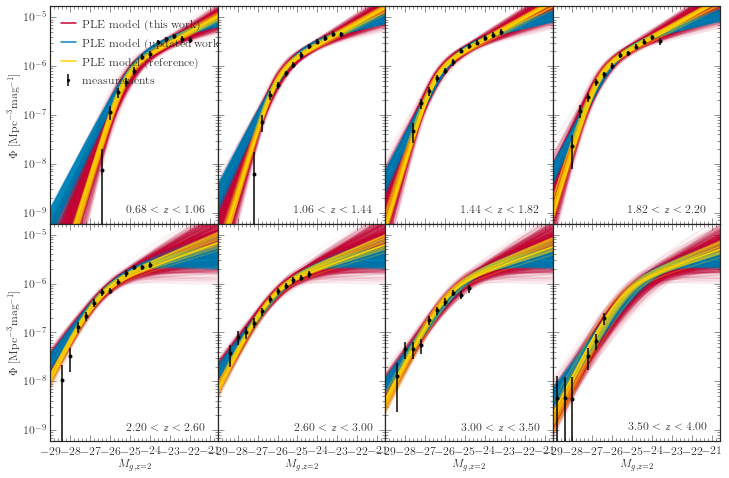

In [12]:
NUM_INTERVALS = 100

NUM_ROW, NUM_COL = 2, 4
ROW_SPAN, COL_SPAN = 4, 3

LEGEND_SETTINGS = dict(
    loc='upper left',
    handlelength=1.2, 
    handletextpad=0.5
)

m = np.linspace(*MAGNITUDE_RANGE, num=NUM_INTERVALS+1)

magnitude_bins = luminosity_function_data.brightness_bins
redshift_bins = luminosity_function_data.redshift_bins
redshift_labels = luminosity_function_data.redshift_labels

plt.figure("eBOSS QSO Luminosity Function", figsize=(12, 8))
for bin_idx, redshift in enumerate(redshift_bins):
    
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL
    
    ax = plt.subplot2grid(
        (NUM_ROW * ROW_SPAN, NUM_COL * COL_SPAN), 
        (row_idx * ROW_SPAN, col_idx * COL_SPAN), 
        rowspan=ROW_SPAN, colspan=COL_SPAN
    )
        
    data_values, data_errors = luminosity_function_data[bin_idx]
    
    if bin_idx == 0:
        plt.errorbar(
            magnitude_bins, data_values, data_errors,
            fmt='o', markersize=4., capsize=0.,
            zorder=3, label='measurements'
        )
        for idx, luminosity_function_model in enumerate(scattered_lum_func0[-1000:]):
            if idx == 0:
                rep0 = plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    zorder=1, label='PLE model (this work)'
                )
            else:
                plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    alpha=0.05, zorder=1, c=rep0[0].get_color()
                )
        for idx, luminosity_function_model in enumerate(scattered_lum_func1[-1000:]):
            if idx == 0:
                rep0 = plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    zorder=1, label='PLE model (updated work)'
                )
            else:
                plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    alpha=0.05, zorder=1, c=rep0[0].get_color()
                )
        for idx, luminosity_function_model in enumerate(reference_lum_func0):
            if idx == 0:
                rep0 = plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    zorder=2, label='PLE model (reference)'
                )
            else:
                plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    alpha=0.25, zorder=2, c=rep0[0].get_color()
                )
        plt.legend(**LEGEND_SETTINGS)
    else:
        plt.errorbar(
            magnitude_bins, data_values, data_errors,
            zorder=3, fmt='o', markersize=4., capsize=0.
        )
        for idx, luminosity_function_model in enumerate(scattered_lum_func0[-1000:]):
            if idx == 0:
                repn = plt.plot(
                    m, luminosity_function_model(m, redshift), zorder=1
                )
            else:
                plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    alpha=0.05, zorder=1, c=repn[0].get_color()
                )
        for idx, luminosity_function_model in enumerate(scattered_lum_func1[-1000:]):
            if idx == 0:
                repn = plt.plot(
                    m, luminosity_function_model(m, redshift), zorder=1
                )
            else:
                plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    alpha=0.05, zorder=1, c=repn[0].get_color()
                )
        for idx, luminosity_function_model in enumerate(reference_lum_func0):
            if idx == 0:
                repn = plt.plot(
                    m, luminosity_function_model(m, redshift), zorder=2
                )
            else:
                plt.plot(
                    m, luminosity_function_model(m, redshift), 
                    alpha=0.25, zorder=2, c=repn[0].get_color()
                )
    plt.xscale('linear')
    plt.xlim(*MAGNITUDE_RANGE)
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        plt.tick_params(
            axis='x', which='both', direction='in', 
            labelbottom=False, labelsize=2
        )
    else:
        plt.xlabel(r"$M_{g,z=2}$")
        
    plt.yscale('log')    
    plt.ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        plt.tick_params(
            axis='y', which='both', direction='in',
            labelleft=False, labelsize=2
        )
    else:
        plt.ylabel(r"$\Phi$ [$\textrm{Mpc}^{-3} \textrm{mag}^{-1}$]")
    
    plt.title(
        redshift_labels[bin_idx], loc='right', position=(0.925, 0.025)
    )

plt.subplots_adjust(hspace=0, wspace=0)